In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
from glasbey import create_palette
import napari
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)
pal = sns.color_palette("dark")
cpal = sns.cubehelix_palette(start=-0.25, rot=2, as_cmap=True)
g_palette = create_palette(2000)

save_path = Path(r"D:\OneDrive - Princeton University\Lab Meetings\2025_04_14 Stas\figures")

Index(['Unnamed: 0', 'ID', 'VISIBILITY', 'RADIUS', 'QUALITY', 'POSITION_T',
       'POSITION_Z', 'POSITION_Y', 'FRAME', 'POSITION_X', 'track_id',
       'position_cluster', 'distance_from_edge', 'tracklet_id', 'parent_id',
       'daughter_id'],
      dtype='object')


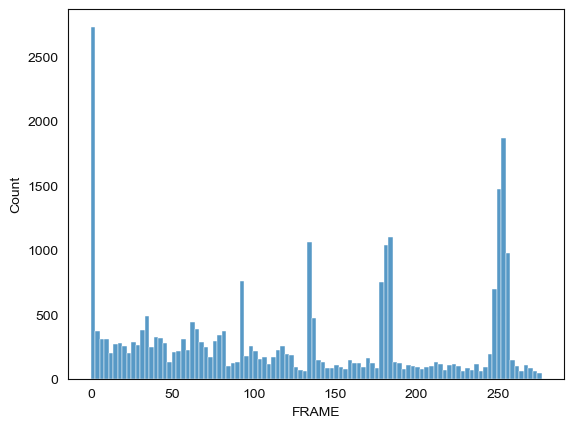

In [3]:
sources = [
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_25_trk\hybrid2\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_21_trk\hybrid2\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_18_trk\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_19a_trk\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_19b_trk\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_01_31\recon\out\tracked_spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon\out\tracked_spots.csv",
    
]

source = r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_19b_trk\hybrid\spots.csv"
source = sources[-1]

df = pd.read_csv(source)
print(df.columns)

sns.histplot(df.groupby("tracklet_id")["FRAME"].min(), bins=100)

plt.show()

viewer = napari.Viewer()

um_per_px = 0.525
df = df[df["FRAME"] == df["FRAME"].max()]
df["x"] = df["POSITION_X"] * um_per_px
df["z"] = df["POSITION_Z"] * um_per_px
df["y"] = df["POSITION_Y"] * um_per_px
pos = np.array(df[["x", "y", "z"]])
pca = PCA(n_components=3)  # Choose the number of components you want to keep
transformed_data = pca.fit_transform(pos)
viewer.add_points(transformed_data[df["FRAME"] == df["FRAME"].max()], size=5, shading="spherical")
napari.run()

In [3]:
sources = [
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_25_trk\hybrid2\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_21_trk\hybrid2\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_18_trk\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_19a_trk\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_19b_trk\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_01_31\recon\out\tracked_spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon\out\tracked_spots.csv"
]

all_cycle_starts = [
    np.array([0, 2, 45, 95, 155, 280]),
    np.array([0, 2, 35, 75, 125, 280]),
    np.array([0, 25, 50, 100, 200, 280]),
    np.array([0, 50, 80, 125, 200, 280]),
    np.array([0, 20, 60, 100, 180, 280]),
    np.array([0, 30, 60, 110, 160, 280]),
    np.array([0, 40, 75, 120, 165, 280]),
    np.array([0, 80, 110, 160, 210, 280]),
]

time_scales = [
    20,
    20,
    20,
    20,
    20,
    22,
    20,
    22,
]

anterior = [
    -214,
    222,
    240,
    240,
    225,
    240,
    240,
    227,
]
posterior = [
    212,
    -196,
    -222,
    -224,
    -233,
    -212,
    -220,
    -212,
]


trk = [
    True,
    True,
    True,
    True,
    True,
    False,
    False,
    False,
]

In [6]:
dfs = []
best_dfs = []
um_per_px = 0.525
best_df_savepath = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\best_dfs")

for i, source in enumerate(sources):
    df = pd.read_csv(source)

    df = df.set_index("ID")

    df["x"] = df["POSITION_X"] * um_per_px
    df["z"] = df["POSITION_Z"] * um_per_px
    df["y"] = df["POSITION_Y"] * um_per_px
    df_last = df[df["FRAME"] == df["FRAME"].max()]
    pos = np.array(df_last[["x", "y", "z"]])
    pca = PCA(n_components=3)
    pca.fit(pos)
    
    transformed_data = pca.transform(np.array(df[["x", "y", "z"]]))
    
    a = anterior[i]
    p = posterior[i]
    
    df["AP_raw"] = transformed_data[:, 0]
    df["AP"] = (df["AP_raw"] - a) / (p - a)
    df["AP_um"] = df["AP"] * np.abs(a - p)
    df["AP_um_centered"] = (df["AP"]-0.5) * np.abs(a - p)
    df["um_from_anterior"] = np.abs(df["AP_raw"] - a)
    df["um_from_posterior"] = np.abs(df["AP_raw"] - p)
    df["distance_to_pole"] = np.min(np.stack([df["um_from_anterior"], df["um_from_posterior"]], axis=-1), axis=-1)
    
    df["theta"] = np.arctan2(transformed_data[:, 1], transformed_data[:, 2])
    
    df["time"] = df["FRAME"] * time_scales[i] / 60
    df["tracklet_start_time"] = df["tracklet_id"].map(df.groupby("tracklet_id")["time"].min())
    
    df["trk"] = trk[i]
    df["source"] = i
    
    cycle_starts = all_cycle_starts[i]
    t_cycle = df.groupby("tracklet_id")["FRAME"].min().apply(lambda time: np.argmax(cycle_starts > time))
    df["cycle"] = df["tracklet_id"].map(t_cycle)
        
    best_df = df[df["track_id"] > 0].copy()
    n_tracklets = best_df["track_id"].map(best_df.groupby("track_id")["tracklet_id"].nunique())
    best_df = best_df[n_tracklets > 1]
    
    t = best_df.groupby("tracklet_id")
    ts = {}
    ts["time_start"] = t["time"].min()
    ts["time_end"] = t["time"].max()
    ts["length"] = t["time"].max() - t["time"].min()
    ts["cycle"] = t["cycle"].first()
    
    tracklets = pd.DataFrame(ts)
    
    cycle_avg_length = tracklets.groupby("cycle")["length"].median()
    
    tracklets["cycle_avg"] = tracklets["cycle"].map(cycle_avg_length)
    tracklets["good"] = np.abs(tracklets["length"] - tracklets["cycle_avg"]) < 6
    
    best_df = best_df[best_df["tracklet_id"].map(tracklets["good"])].copy()
    
    nc11 = all_cycle_starts[i][2]
    frame = best_df[best_df["FRAME"] == nc11]
    nc11_time = frame["tracklet_start_time"].median()
    df["time_since_nc11"] = df["time"] - nc11_time
    best_df["time_since_nc11"] = best_df["time"] - nc11_time
    
    dfs.append(df)
    best_dfs.append(best_df)

    stem = source.split('\\')[6]

    # best_df.to_csv(best_df_savepath / f"{stem}_best_spots.csv")

In [8]:
df_all = pd.concat(best_dfs, ignore_index=True)
df_all["tracklet_src"] = df_all["tracklet_id"].astype(str) + df_all["source"].astype(str)

In [36]:
df_all["ap_bin"] = pd.cut(df_all["AP"], 20)

x, y, c = [], [], []

for name, group in df_all.groupby(["source", "ap_bin"]):
    # if name[0] !=  3:
    #     continue

    a = group[group["cycle"] == 3]
    start = a.groupby("tracklet_id")["time"].min().mean()
    end = a.groupby("tracklet_id")["time"].max().mean()
    x.append(end - start)

    b = group[group["cycle"] == 4]
    start = b.groupby("tracklet_id")["time"].min().mean()
    end = b.groupby("tracklet_id")["time"].max().mean()
    y.append(end - start)

    c.append(str(name[0]))

C:\Users\Harrison\AppData\Local\Temp\ipykernel_16740\883113689.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df_all.groupby(["source", "ap_bin"]):


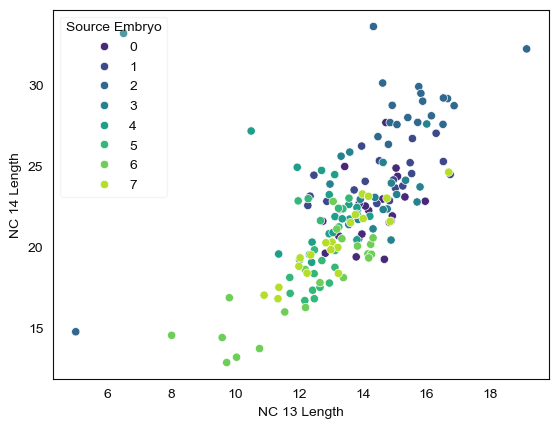

In [40]:
sns.scatterplot(x=x, y=y, hue=c, palette="viridis")
plt.xlabel("NC 13 Length")
plt.ylabel("NC 14 Length")
plt.legend(title = "Source Embryo", loc= "upper left")
plt.savefig(r"D:\OneDrive - Princeton University\Lab Meetings\2025_06_04 Toettch\timecorr.png", dpi=150)
plt.show()

In [14]:
x

[24.994152046783647,
 21.61250000000001,
 20.707379134860062,
 19.631578947368418,
 19.406504065040664,
 20.529953917050676,
 21.55140186915888,
 21.93925233644859,
 22.84757118927972,
 24.897849462365592,
 24.385585585585595,
 22.98299319727891,
 22.273996509598597,
 22.54945054945056,
 22.701863354037272,
 20.818181818181827,
 19.25738396624474,
 21.61274509803922,
 23.112318840579732,
 27.711711711711708,
 26.722222222222214,
 26.257383966244724,
 24.458333333333336,
 22.58333333333333,
 23.16098484848486,
 22.347417840375577,
 22.84255319148936,
 22.706507304116855,
 23.665294924554182,
 24.55652173913044,
 25.302631578947377,
 24.502949852507378,
 23.792227204783266,
 24.16212121212122,
 22.884322678843212,
 23.544117647058826,
 24.077898550724626,
 25.230019493177394,
 25.34741784037559,
 27.048387096774206,
 25.33333333333332,
 33.64912280701754,
 30.15530303030304,
 26.364963503649626,
 26.840490797546025,
 27.70967741935484,
 27.587227414330222,
 28.776255707762573,
 28.021097

In [23]:
best_dfs[0].columns

Index(['Unnamed: 0', 'ID', 'VISIBILITY', 'RADIUS', 'QUALITY', 'POSITION_T',
       'POSITION_X', 'POSITION_Y', 'FRAME', 'POSITION_Z', 'graph_key',
       'linear_track_id', 'interpolated', 'is_swapped', 'track_id',
       'tracklet_id', 'parent_id', 'n_children', 'n_parents',
       'tracklet_first_parent_id', 'tracklet_parent_tracklet', 'x', 'z', 'y',
       'AP_raw', 'AP', 'AP_um', 'AP_um_centered', 'um_from_anterior',
       'um_from_posterior', 'distance_to_pole', 'theta', 'time',
       'tracklet_start_time', 'trk', 'cycle', 'time_since_nc11'],
      dtype='object')

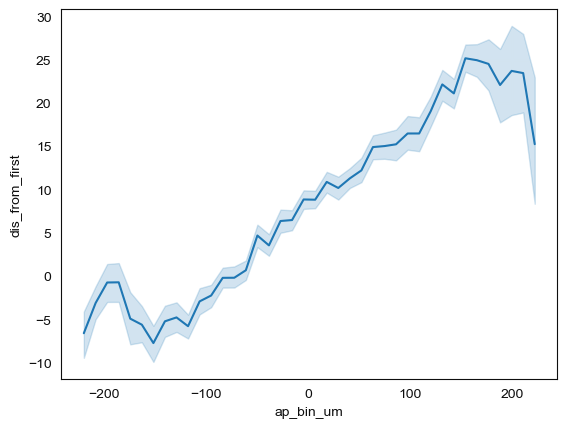

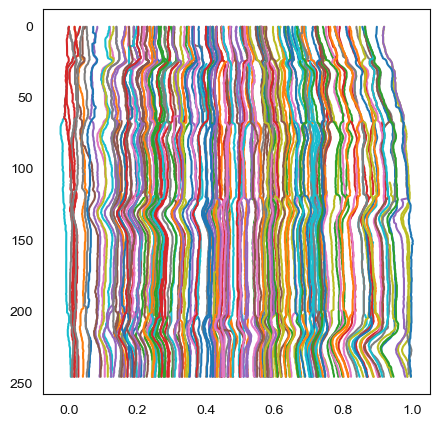

In [29]:
best_df = best_dfs[0].copy()
best_df = best_df.set_index("ID")
best_df = best_df.sort_values(by="FRAME")

x_cat = "AP_um_centered"

best_df["first_spot_ap"] = best_df["track_id"].map(best_df.groupby("track_id")[x_cat].first())

best_df["dis_from_first"] = best_df[x_cat] - best_df["first_spot_ap"]

x = pd.cut(best_df[x_cat], bins=40)
x = x.apply(lambda v: (v.left + v.right) / 2)
best_df["ap_bin_um"] = x

# sns.boxplot(best_df[best_df["FRAME"] == best_df["FRAME"].max()], x="ap_bin_um", y="dis_from_first")
sns.lineplot(best_df[best_df["FRAME"] == best_df["FRAME"].max()], x="ap_bin_um", y="dis_from_first")
plt.show()


# print(best_df.index)

# best_df

pts = best_df[best_df["time"] == best_df["time"].max()].sample(200).index

x = "AP"
y = "FRAME"

gix, ax = plt.subplots(1, 1, figsize=(5, 5))

for pt in pts:

    x_vals = []
    y_vals = []

    while best_df.loc[pt, "parent_id"] != -1:
        x_vals.append(best_df.loc[pt, x])
        y_vals.append(best_df.loc[pt, y])
        pt = best_df.loc[pt, "parent_id"]

        if pt not in best_df.index:
            break

    ax.plot(x_vals, y_vals)

ax.invert_yaxis()
plt.show()

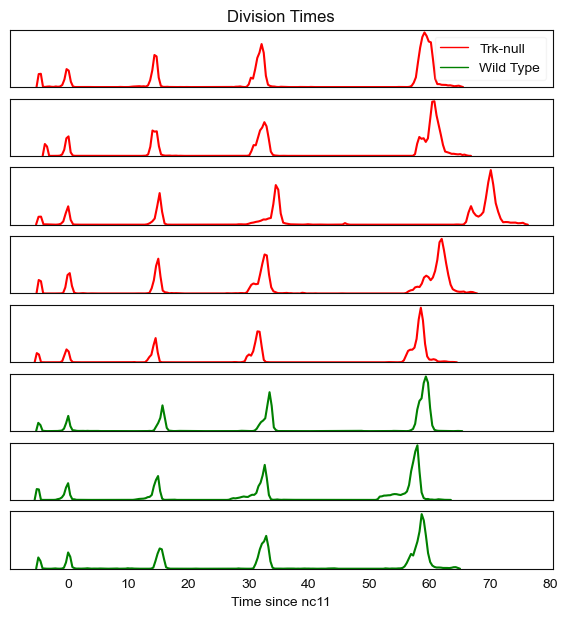

In [5]:
fig, axes = plt.subplots(8, 1, sharex=True, figsize=(7, 7))

colors = ["green", "red"]

for i, (df, ax) in enumerate(zip(best_dfs, axes.flatten())):
    
    color = colors[trk[i]]
    
    sns.kdeplot(x=df[df["time_since_nc11"]>-5].groupby("tracklet_id")["time_since_nc11"].min(), color=color, ax=ax,
                bw_adjust=0.05)
    
    # t = df[df["time_since_nc10"]>-5].groupby("tracklet_id")
    # sns.kdeplot(x=t["time_since_nc10"].min(), hue=t["cycle"].first(), ax=ax,
    #             bw_adjust=0.05)
    # 
    ax.set_ylabel("")
    ax.set_yticks([])
    # ax.vlines([0], 0, 0.25, color="k")
    
plt.xlabel("Time since nc11")
axes[0].set_title("Division Times")

from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color=colors[1], lw=1),
                Line2D([0], [0], color=colors[0], lw=1)]

axes[0].legend(custom_lines, ["Trk-null", "Wild Type"], loc="upper right")

plt.savefig(save_path / "division_times.png", dpi=300)

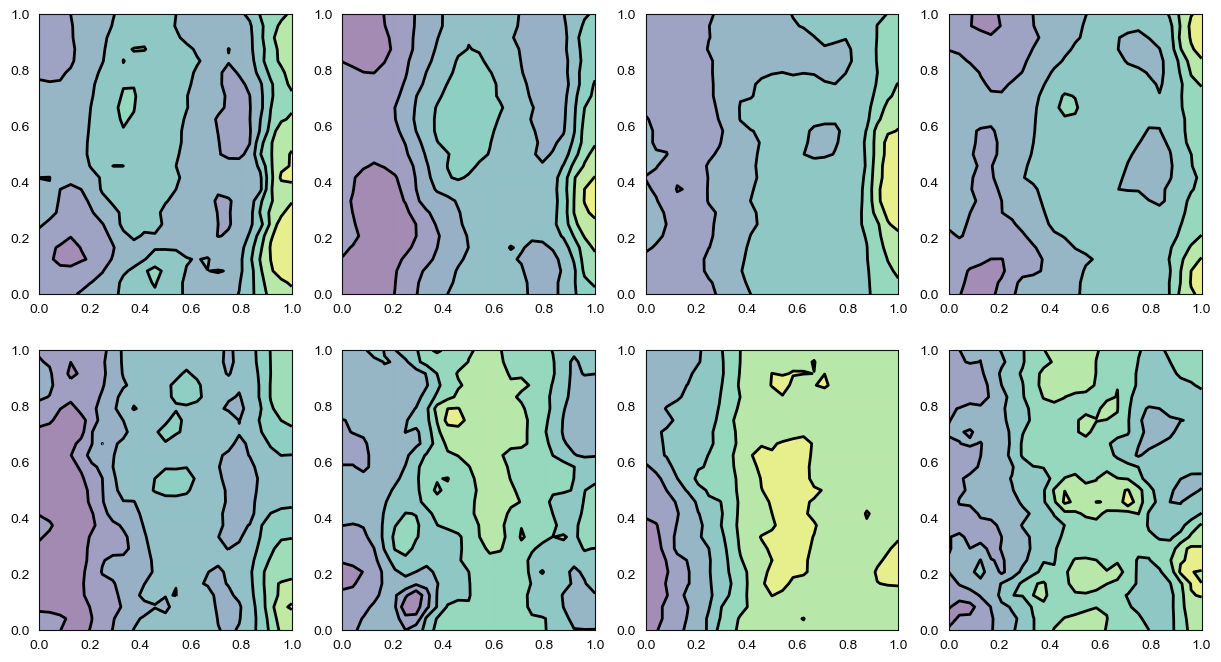

In [7]:
from sklearn.neighbors import NearestNeighbors

def get_contour(x, y, z, n=50):
    
    x = (x.copy()  - x.min())/ (x.max() - x.min())
    y = (y.copy()  - y.min())/ (y.max() - y.min())
    
    tester = NearestNeighbors()
    tester.fit(np.array([x, y]).T)
    
    
    x_bins = np.linspace(x.min(), x.max(), n)
    y_bins = np.linspace(y.min(), y.max(), n)
    X, Y = np.meshgrid(x_bins, y_bins)
    
    Z = np.zeros_like(X)
    for i, x_bin in enumerate(x_bins):
        for j, y_bin in enumerate(y_bins):
            _, indices = tester.kneighbors([[x_bin, y_bin]], 25)
            Z[j, i] = np.mean([z[idx] for idx in indices[0]])

    return X, Y, Z

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
cycle = 4


for i, (df, ax) in enumerate(zip(best_dfs, axes.flatten())):
    
    t = df[df["cycle"] == cycle].groupby("tracklet_id")
    
    x = t["AP"].last()
    y = t["theta"].last()
    z = np.array(t["time"].max())
    z = z - np.mean(z)
    
    X, Y, Z = get_contour(x, y, z, n=25)
    
    plt.sca(ax)
    plt.contourf(X, Y, Z, levels=6, cmap="viridis", alpha=0.5)
    plt.contour(X, Y, Z, levels=6, colors="k", linewidths=2, linestyles="solid")

plt.savefig(save_path / f"ap_division_cycle_{cycle + 10}_contour.png", dpi=300)
plt.show()


In [6]:
# from scipy.spatial.distance import cdist
#
# kd = 50
# vol = np.pi * kd**2
# print(vol)
#
# for i, (df, ax) in enumerate(zip(best_dfs, axes.flatten())):
#
#     t = df[df["cycle"] == cycle].groupby("tracklet_id")
#
#     position = t[["x", "y", "z"]].last()
#     div_time = t["time"].max()
#     ap = t["AP"].last()
#
#     distances = cdist(position, position)
#
#     is_neighbor = distances < kd
#     neighbors = np.sum(is_neighbor, axis = -1)
#
#     xx, yy = np.meshgrid(div_time, div_time)
#     mean_time = np.sum(xx * is_neighbor, axis=-1) / neighbors
#
#     xx, yy = np.meshgrid(mean_time, mean_time)
#
#     vals = [xx[i, is_neighbor[i]] for i in range(len(neighbors))]
#     qlo = np.array([np.quantile(val, 0.1) for val in vals])
#     qhi = np.array([np.quantile(val, 0.9) for val in vals])
#
#     # print(qhi - qlo)
#
#     # sns.scatterplot(x = ap, y = (2*kd/60)/(qhi- qlo))
#     # sns.scatterplot(x = ap, y = div_time - np.mean(div_time), color="k")
#     sns.scatterplot(x=neighbors/vol, y=(2*kd/60)/(qhi- qlo))
#
#     plt.show()

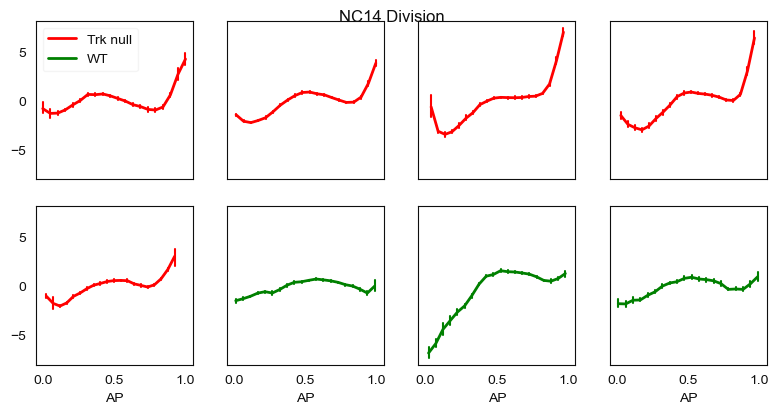

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(8, 4), sharex=True, sharey=True)
cycle = 4

plt.tight_layout()


for i, (df, ax) in enumerate(zip(best_dfs, axes.flatten())):
    
    color = colors[trk[i]]
    
    t = df[df["cycle"] == cycle].groupby("tracklet_id")
    
    x = pd.cut(t["AP"].last(), 20)
    x = x.apply(lambda v: (v.left + v.right) / 2)
    y = np.array(t["time"].max())
    
    y = y - np.mean(y)
    
    sns.lineplot(x=x, y=y, ax=ax, errorbar="ci", err_style="bars", color=color, lw=2)
    

custom_lines = [Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[0], lw=2)]

axes.flatten()[0].legend(custom_lines, ["Trk null", "WT"])

plt.savefig(save_path / f"ap_division_cycle_{cycle + 10}_line.png", dpi=300)
plt.suptitle(f"NC{cycle + 10} Division")

plt.show()

In [10]:
palette = sns.color_palette("mako", n_colors=5)[0:]

wave_path = Path(r"D:\OneDrive - Princeton University\Lab Meetings\2025_04_14 Stas\figures\individual_waves")

def jitter(x, factor=0.05):
    return x + factor*np.random.randn(len(x))

k = 3

for i, df in enumerate(best_dfs):

    for cycle in range(1, 4):
        this_df = df[df["cycle"] == cycle]
        
        t = this_df.groupby("tracklet_id")
        valid = np.array([True]*len(t))
        
        for factor in [t["time"].max(), t["time"].min(), t["time"].max() - t["time"].min()]:
            factor_mean = factor.mean()
            factor_std = factor.std()
            # print(start_mean - k*start_std, start_mean + k*start_std)
            # print(factor.between(factor_mean - k*factor_std, factor_mean + k*factor_std))
            valid = valid * factor.between(factor_mean - k*factor_std, factor_mean + k*factor_std)
            
        x = t["AP"].last()[valid]
        y = np.array(t["time"].max())[valid]
        
        this_path = wave_path / f"end_time_{chr(ord('A') + i)}_{'trk' if trk[i] else 'wt'}"
        this_path.mkdir(parents=True, exist_ok=True)
        
        sns.scatterplot(x=x, y=y, color=palette[cycle + 1], edgecolors="k")
        plt.gca().invert_yaxis()
        plt.title(f"Cycle {cycle + 10}")
        plt.xlabel("AP Position")
        plt.ylabel("Division time (min)")
        x_binned = [(a.right + a.left)/2 for a in pd.cut(x, bins=20)]
        sns.lineplot(x=x_binned, y=y, color="black")
        # sns.lineplot(t, x="AP", y="time_start", color=palette[cycle], alpha=0.5)
        plt.savefig(this_path /f"wave_cycle_{cycle}.png", dpi=300, bbox_inches="tight")
        plt.close()

In [68]:
from collections import defaultdict




# plt.tight_layout()

wave_fronts = defaultdict(list)

for cycle in [2, 3, 4]:

    # fig, axes = plt.subplots(2, 4, figsize=(8, 4), sharex=True, sharey=True)

    for i, (df, ax) in enumerate(zip(best_dfs, axes.flatten())):

        color = colors[trk[i]]

        t = df[df["cycle"] == cycle].groupby("tracklet_id")

        x = pd.cut(np.clip(t["AP"].last(), 0, 1), 40)
        x = np.array(x.apply(lambda v: (v.left + v.right) / 2))
        y = np.array(t["time"].max())

        y = y - np.mean(y)

        bg = t["time"].max().groupby(x, observed=True).mean()

        a_half = bg[bg.index < 0.5]
        mean_a = a_half.index[a_half.argmin()]
        p_half = bg[bg.index > 0.5]
        mean_p = p_half.index[p_half.argmin()]

        wave_fronts["condition"].append("Trk-null" if trk[i] else "Wild Type")
        wave_fronts["cycle"].append(cycle + 9)
        wave_fronts["anterior"].append(mean_a)
        wave_fronts["posterior"].append(1 - mean_p)
        wave_fronts["wave_magnitude"].append(np.mean(np.abs((y))))

        cycle_length = np.array(t["time"].max()) - np.array(t["time"].mean())

        wave_fronts["length_magnitude"].append(np.mean(np.abs(cycle_length - cycle_length.mean())))


        # sns.lineplot(x=x, y=y, ax=ax, errorbar="ci", err_style="bars", color=color, lw=2)
        # ax.vlines([mean_a, mean_p], 0, 1, transform=ax.get_xaxis_transform())

    # custom_lines = [Line2D([0], [0], color=colors[1], lw=2),
    #                 Line2D([0], [0], color=colors[0], lw=2)]

    # axes.flatten()[0].legend(custom_lines, ["Trk null", "WT"])
    #
    # plt.savefig(save_path / f"ap_division_cycle_{cycle + 10}_line.png", dpi=300)
    # plt.suptitle(f"NC{cycle + 10} Division")
    #
    # plt.close()

wave_fronts = pd.DataFrame(wave_fronts)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

12 vs. 13: t-test independent samples, P_val:3.320e-02 t=-2.362e+00
11 vs. 12: t-test independent samples, P_val:1.790e-03 t=-3.844e+00
11 vs. 13: t-test independent samples, P_val:5.074e-04 t=-4.491e+00


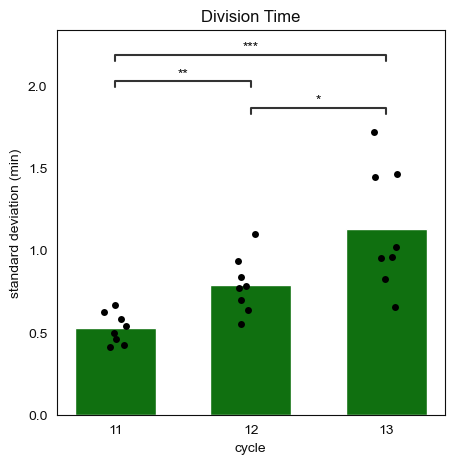

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

12 vs. 13: t-test independent samples, P_val:6.926e-02 t=-1.968e+00
11 vs. 12: t-test independent samples, P_val:3.902e-01 t=-8.868e-01
11 vs. 13: t-test independent samples, P_val:2.299e-02 t=-2.553e+00


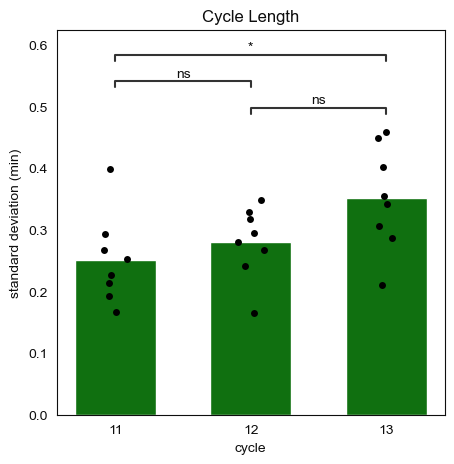

In [69]:
from collections import defaultdict
from statannotations.Annotator import Annotator

fig, ax = plt.subplots(1,1, figsize=(5, 5))

x = "cycle"
y = "wave_magnitude"

sns.barplot(data=wave_fronts, x=x, y=y, color="green", ax=ax, width=0.6, errorbar=None)
sns.stripplot(data=wave_fronts, x=x, y=y,color="k", order=[11, 12, 13], dodge=True, ax=ax, legend=False)

pairs = [(12, 13), (11, 13), (11, 12)]

annot = Annotator(None, pairs)
annot.new_plot(ax, pairs, plot='barplot',
           data=wave_fronts, x=x, y=y)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=1)
annot.apply_test().annotate()

plt.ylabel(f"standard deviation (min)")
plt.xlabel("cycle")
# ax.legend(title="")
plt.title(f"Division Time")
plt.savefig(save_path / f"division_time_std.png", dpi=300)
plt.show()


fig, ax = plt.subplots(1,1, figsize=(5, 5))

x = "cycle"
y = "length_magnitude"

sns.barplot(data=wave_fronts, x=x, y=y, color="green", ax=ax, width=0.6, errorbar=None)
sns.stripplot(data=wave_fronts, x=x, y=y,color="k", order=[11, 12, 13], dodge=True, ax=ax, legend=False)

pairs = [(12, 13), (11, 13), (11, 12)]

annot = Annotator(None, pairs)
annot.new_plot(ax, pairs, plot='barplot',
           data=wave_fronts, x=x, y=y)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=1)
annot.apply_test().annotate()

plt.ylabel(f"standard deviation (min)")
plt.xlabel("cycle")
# ax.legend(title="")
plt.title(f"Cycle Length")
plt.savefig(save_path / f"cycle_length_std.png", dpi=300)
plt.show()

In [75]:
best_dfs[0].columns

Index(['Unnamed: 0', 'ID', 'VISIBILITY', 'RADIUS', 'QUALITY', 'POSITION_T',
       'POSITION_X', 'POSITION_Y', 'FRAME', 'POSITION_Z', 'graph_key',
       'linear_track_id', 'reflection_z', 'reflection_x', 'is_reflected',
       'display_x', 'display_z', 'interpolated', 'is_swapped', 'track_id',
       'tracklet_id', 'x', 'z', 'y', 'AP_raw', 'AP', 'AP_um', 'AP_um_centered',
       'um_from_anterior', 'um_from_posterior', 'distance_to_pole', 'theta',
       'time', 'tracklet_start_time', 'trk', 'cycle', 'time_since_nc11'],
      dtype='object')

In [77]:
# for i, df in enumerate(best_dfs):
#
#     t = {}
#     tracklets = df.groupby("tracklet_id")
#     t["track_id"] = tracklets["track_id"].first()
#     t["start_time"] = tracklets["time"].min()
#     t["end_time"] = tracklets["time"].max()
#     t["cycle"] = tracklets["cycle"].first()
#
#     t = pd.DataFrame(t)
#
#     t["length"] = t["end_time"] - t["start_time"]
#
#     tt = {}
#     for cycle in [2, 3, 4]:
#         tt[f"{cycle}"] = t[t["cycle"] == cycle].groupby("track_id")["length"].mean()
#
#     tt = pd.DataFrame(tt)
#
#     sns.scatterplot(tt, x="3", y="4")
#     plt.show()

C:\Users\Harrison\.conda\envs\btc-test\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

13_Wild Type vs. 13_Trk-null: t-test independent samples, P_val:3.546e-02 t=-2.702e+00
12_Wild Type vs. 12_Trk-null: t-test independent samples, P_val:1.424e-01 t=-1.688e+00


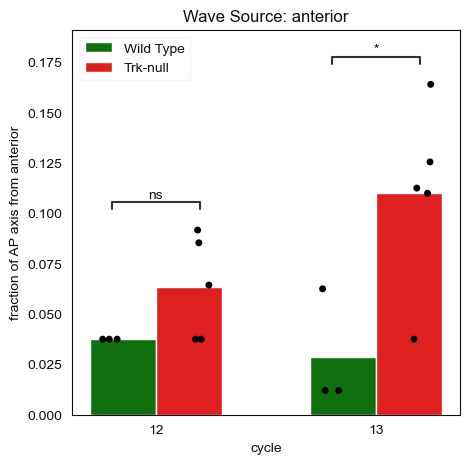

In [47]:
from collections import defaultdict
from statannotations.Annotator import Annotator

fig, ax = plt.subplots(1,1, figsize=(5, 5))

x = "cycle"
y = "anterior"
hue = "condition"
hue_order = ["Wild Type", "Trk-null"]

sns.barplot(data=wave_fronts, x=x, y=y, hue=hue, palette=colors, hue_order=hue_order, ax=ax, width=0.6, errorbar=None)
sns.stripplot(data=wave_fronts, x=x, y=y, hue=hue, palette=["k", "k"], order=[11, 12, 13], dodge=True, hue_order=hue_order, ax=ax, legend=False)

pairs = [((cycle, "Wild Type"), (cycle, "Trk-null")) for cycle in [12, 13]]

annot = Annotator(None, pairs)
annot.new_plot(ax, pairs, plot='boxplot',
           data=wave_fronts, x=x, y=y, hue=hue, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=1)
annot.apply_test().annotate()

plt.ylabel(f"fraction of AP axis from {y}")
plt.xlabel("cycle")
ax.legend(title="")
plt.title(f"Wave Source: {y}")
plt.savefig(save_path / f"wave_source_{y}.png", dpi=300)
plt.show()

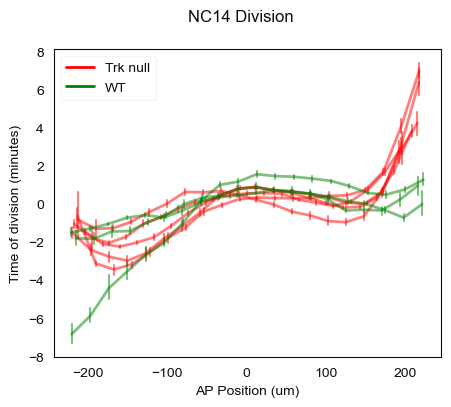

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
cycle = 4

# plt.tight_layout()

for i, df in enumerate(best_dfs):
    
    color = colors[trk[i]]
    
    t = df[df["cycle"] == cycle].groupby("tracklet_id")
    
    x = pd.cut(t["AP_um_centered"].last(), 20)
    x = x.apply(lambda v: (v.left + v.right) / 2)
    y = np.array(t["time"].max())
    
    y = y - np.mean(y)
    
    sns.lineplot(x=x, y=y, ax=ax, errorbar="ci", err_style="bars", color=color, lw=2, alpha=0.5)
    # sns.lineplot(x=x, y=y, ax=ax, errorbar="ci", err_style="bars", lw=2, alpha=0.5, label=i)
    # sns.lineplot(x=x, y=y, ax=ax, errorbar="ci", err_style="bars", color=i, lw=2, alpha=0.5)
    

custom_lines = [Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[0], lw=2)]

ax.legend(custom_lines, ["Trk null", "WT"])
ax.set_ylabel("Time of division (minutes)")
ax.set_xlabel("AP Position (um)")

plt.suptitle(f"NC{cycle + 10} Division")
plt.savefig(save_path / f"ap_division_cycle_{cycle + 10}_single_line.png", dpi=300)

plt.show()

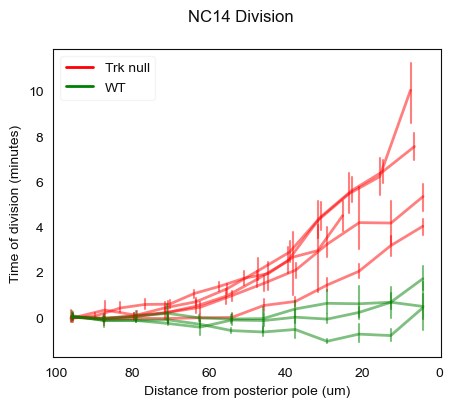

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
cycle = 4

# plt.tight_layout()

for i, df in enumerate(best_dfs):
    
    color = colors[trk[i]]
        
    t = df[df["cycle"] == cycle].groupby("tracklet_id")
    tdf = {}
    tdf["ap_last"] = t["AP"].last()
    tdf["um_last"] = t["um_from_posterior"].last()
    tdf["end"] = t["time"].max()
    
    t = pd.DataFrame(tdf)
    
    t2 = t[t["um_last"] < 100]
    
    x = pd.cut(t2["um_last"], 12)
    x = x.apply(lambda v: (v.left + v.right) / 2)
    
    last = t2[t2["um_last"].between(90, 100)]["end"].mean()
    
    y = np.array(t2["end"])
    
    y = y - last
    
    sns.lineplot(x=x, y=y, ax=ax, errorbar=("ci", 95), err_style="bars", color=color, lw=2, alpha=0.5)
    

custom_lines = [Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[0], lw=2)]

ax.legend(custom_lines, ["Trk null", "WT"])
ax.set_ylabel("Time of division (minutes)")
ax.set_xlabel("Distance from posterior pole (um)")
ax.invert_xaxis()

plt.suptitle(f"NC{cycle + 10} Division")
plt.savefig(save_path / f"ap_division_cycle_{cycle + 10}_from_p.png", dpi=300)

plt.show()

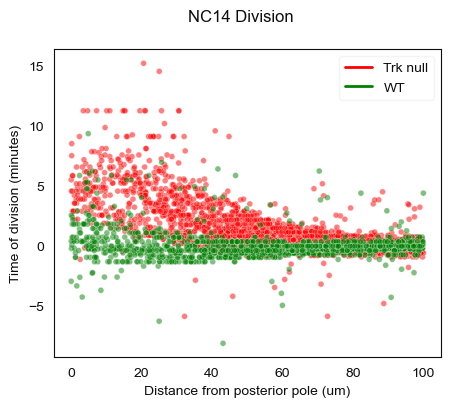

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
cycle = 4

# plt.tight_layout()

for i, df in enumerate(best_dfs):
    
    color = colors[trk[i]]
        
    t = df[df["cycle"] == cycle].groupby("tracklet_id")
    tdf = {}
    tdf["ap_last"] = t["AP"].last()
    tdf["um_last"] = t["um_from_posterior"].last()
    tdf["end"] = t["time"].max()
    
    t = pd.DataFrame(tdf)
    
    t = t[t["um_last"] < 100]
    
    x = t["um_last"]
    # x = pd.cut(t["um_last"], 15)
    # x = x.apply(lambda v: (v.left + v.right) / 2)
    
    last = t[t["um_last"] > 90]["end"].mean()
    
    y = np.array(t["end"])
    
    y = y - last
    
    sns.scatterplot(x=x, y=y, ax=ax, alpha=0.5, size=2, color=color)
    

custom_lines = [Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[0], lw=2)]

ax.legend(custom_lines, ["Trk null", "WT"])
ax.set_ylabel("Time of division (minutes)")
ax.set_xlabel("Distance from posterior pole (um)")

plt.suptitle(f"NC{cycle + 10} Division")
plt.savefig(save_path / f"ap_division_cycle_{cycle + 10}_from_p_scatter.png", dpi=300)

plt.show()

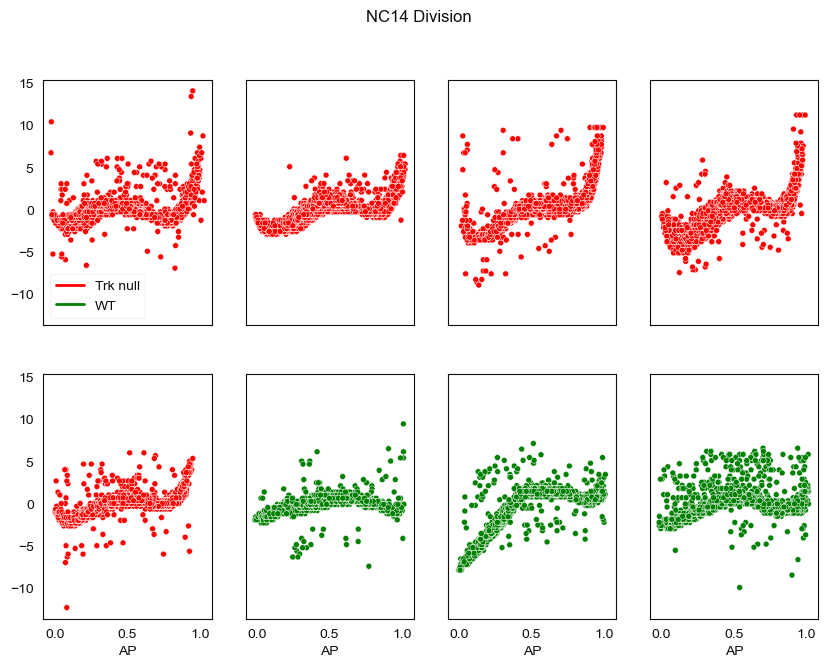

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(10,  7), sharex=True, sharey=True)
cycle = 4


for i, (df, ax) in enumerate(zip(best_dfs, axes.flatten())):
    
    color = colors[trk[i]]
    
    t = df[df["cycle"] == cycle].groupby("tracklet_id")
    
    x = t["AP"].last()
    # x = pd.cut(t["AP"].last(), 20)
    # x = x.apply(lambda v: (v.left + v.right) / 2)
    y = np.array(t["time"].max())
    
    y = y - np.mean(y)
    
    sns.scatterplot(x=x, y=y, ax=ax, color=color, size=1, legend=False)


custom_lines = [Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[0], lw=2)]

axes.flatten()[0].legend(custom_lines, ["Trk null", "WT"])

plt.savefig(save_path / f"ap_division_cycle_{cycle + 10}_scatter.png", dpi=300)
plt.suptitle(f"NC{cycle + 10} Division")

plt.show()

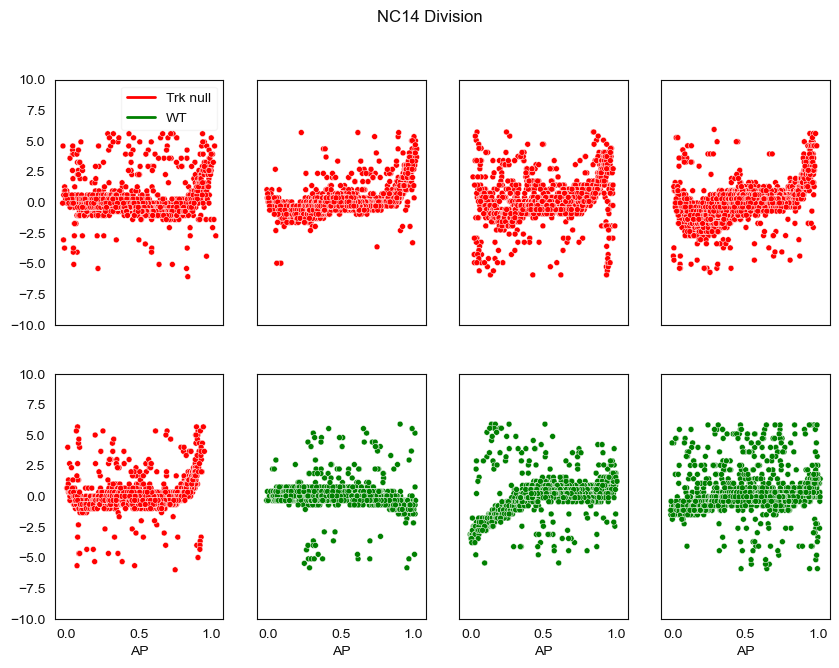

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(10,  7), sharex=True, sharey=True)
cycle = 4


for i, (df, ax) in enumerate(zip(best_dfs, axes.flatten())):
    
    color = colors[trk[i]]
    
    t = df[df["cycle"] == cycle].groupby("tracklet_id")
    
    x = t["AP"].last()
    # x = pd.cut(t["AP"].last(), 20)
    # x = x.apply(lambda v: (v.left + v.right) / 2)
    y = np.array(t["time"].max() - t["time"].min())
    
    y = y - np.mean(y)
    
    sns.scatterplot(x=x, y=y, ax=ax, color=color, size=1, legend=False)
    
    ax.set_ylim([-10, 10])


custom_lines = [Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[0], lw=2)]

axes.flatten()[0].legend(custom_lines, ["Trk null", "WT"])

plt.savefig(save_path / f"ap_division_cycle_length_{cycle + 10}_scatter.png", dpi=300)
plt.suptitle(f"NC{cycle + 10} Division")

plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

12_Wild Type vs. 12_Trk-null: Mann-Whitney-Wilcoxon test two-sided, P_val:2.500e-01 U_stat=3.000e+00
11_Wild Type vs. 11_Trk-null: Mann-Whitney-Wilcoxon test two-sided, P_val:1.429e-01 U_stat=1.300e+01
13_Wild Type vs. 13_Trk-null: Mann-Whitney-Wilcoxon test two-sided, P_val:3.571e-02 U_stat=0.000e+00


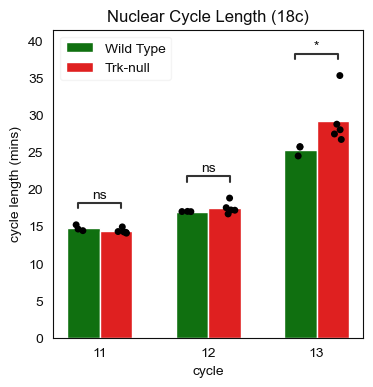

In [16]:
from collections import defaultdict
from statannotations.Annotator import Annotator

fig, ax = plt.subplots(1,1, figsize=(4, 4))

embryos = defaultdict(list)
for i, df in enumerate(best_dfs):
    for cycle in [2, 3, 4]:
        this_df = df[df["cycle"] == cycle]
        t = this_df.groupby("tracklet_id")
        
        embryos["cycle"].append(cycle + 9)
        embryos["length"].append(np.mean(t["time"].max() - t["time"].min()))
        embryos["trk"].append(trk[i])
        embryos["trk_label"].append("Trk-null" if trk[i] else "Wild Type")
        
embryos_df = pd.DataFrame(embryos)

x = "cycle"
y = "length"
hue = "trk_label"
hue_order = ["Wild Type", "Trk-null"]

sns.barplot(data=embryos_df, x=x, y=y, hue=hue, palette=colors, hue_order=hue_order, ax=ax, errorbar=None, width=0.6)
sns.stripplot(data=embryos_df, x=x, y=y, hue=hue, palette=["k", "k"], order=[11, 12, 13], dodge=True, hue_order=hue_order, ax=ax, legend=False)

pairs = [((cycle, "Wild Type"), (cycle, "Trk-null")) for cycle in [11, 12, 13]]

annot = Annotator(None, pairs)
annot.new_plot(ax, pairs, plot='barplot',
           data=embryos_df, x=x, y=y, hue=hue, hue_order=hue_order)
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=1)
annot.apply_test().annotate()

plt.ylabel("cycle length (mins)")
plt.xlabel("cycle")
ax.legend(title="")
plt.title("Nuclear Cycle Length (18c)")
plt.savefig(save_path / "nuclear_cycle_length_comparison.png", dpi=300)
plt.show()

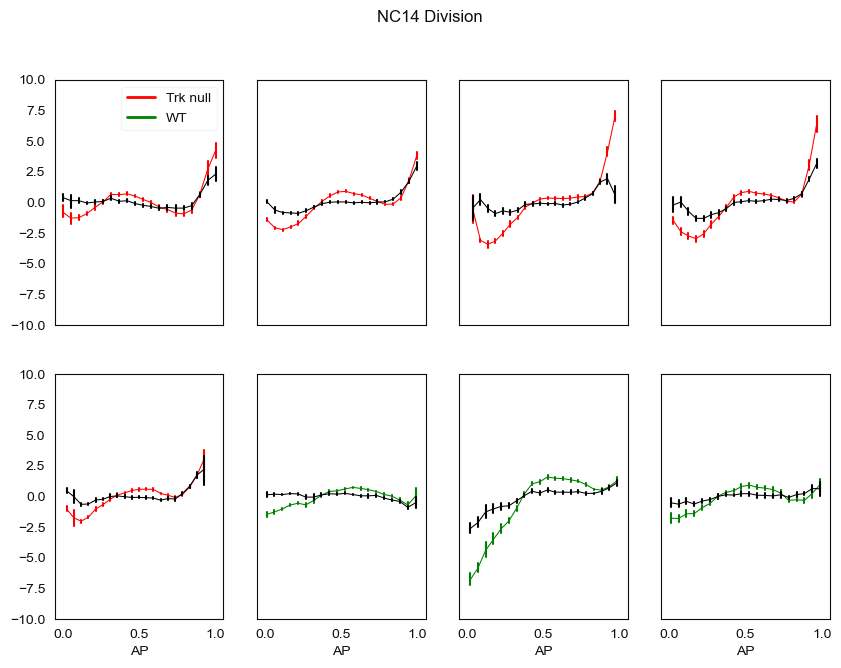

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(10,  7), sharex=True, sharey=True)
cycle = 4


for i, (df, ax) in enumerate(zip(best_dfs, axes.flatten())):
    
    color = colors[trk[i]]
    
    t = df[df["cycle"] == cycle].groupby("tracklet_id")
    
    x = t["AP"].last()
    x = pd.cut(t["AP"].last(), 20)
    x = x.apply(lambda v: (v.left + v.right) / 2)
    
    y = np.array(t["time"].max())
    y = y - np.mean(y)
    sns.lineplot(x=x, y=y, ax=ax, color=color, size=1, legend=False, err_style="bars", dashes=True)
    
    y = np.array(t["time"].max() - t["time"].min())
    y = y - np.mean(y)
    sns.lineplot(x=x, y=y, ax=ax, color="k", size=1, legend=False, err_style="bars", dashes=False)
    
    ax.set_ylim([-10, 10])


custom_lines = [Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[0], lw=2)]

axes.flatten()[0].legend(custom_lines, ["Trk null", "WT"])

plt.savefig(save_path / f"ap_division_cycle_length_{cycle + 10}_comparison.png", dpi=300)
plt.suptitle(f"NC{cycle + 10} Division")

plt.show()

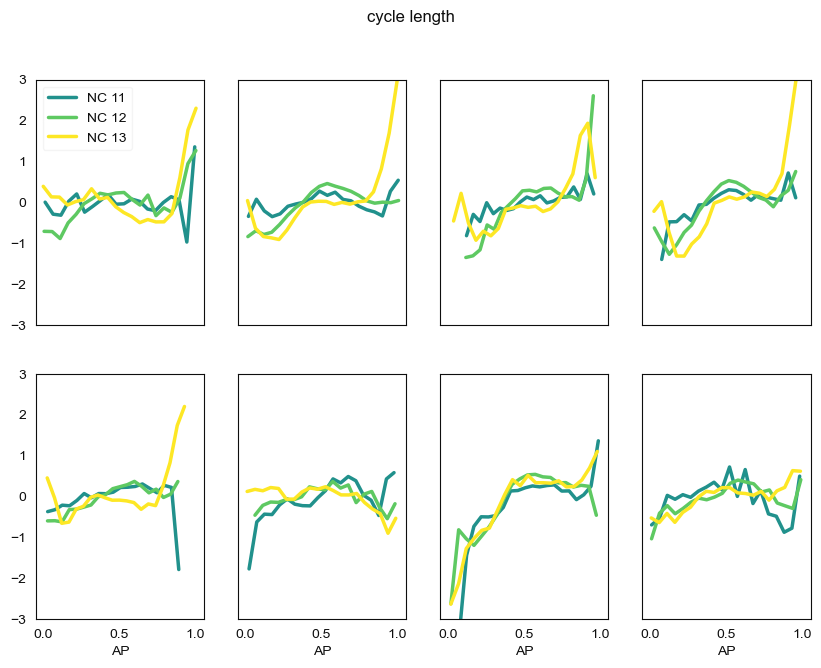

In [18]:
plt.show()
fig, axes = plt.subplots(2, 4, figsize=(10, 7), sharex=True, sharey=True)
cycle = 4

for i, (df, ax) in enumerate(zip(best_dfs, axes.flatten())):
    for cycle in [2, 3, 4]:
        color = sns.color_palette("viridis", as_cmap=True)(cycle/4)
    
        t = df[df["cycle"] == cycle].groupby("tracklet_id")
    
        x = t["AP"].last()
        x = pd.cut(t["AP"].last(), 20)
        x = x.apply(lambda v: (v.left + v.right) / 2)
        
        num_in_bin = x.value_counts() > len(x) * 0.01
        counts = x.map(num_in_bin)
        
        y = np.array(t["time"].max() - t["time"].min())
        y = y - np.mean(y)
        sns.lineplot(x=x[counts], y=y[counts], ax=ax, color=color, legend=False, err_style=None, label=f"NC {cycle + 9}", 
                     lw=2.5)
    
        ax.set_ylim([-3, 3])

# custom_lines = [Line2D([0], [0], color=colors[1], lw=2),
#                 Line2D([0], [0], color=colors[0], lw=2)]
# 
# axes.flatten()[0].legend(custom_lines, ["Trk null", "WT"])
axes.flatten()[0].legend()


plt.savefig(save_path / f"ap_division_cycle_length_all_cycles.png", dpi=300)
plt.suptitle(f"cycle length")

plt.show()

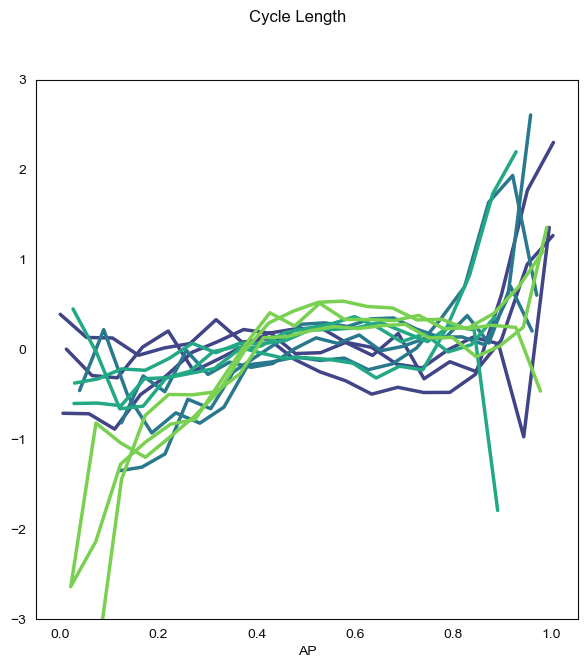

In [76]:
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

for i, df in enumerate(best_dfs[:8:2]):
    for cycle in [2, 3, 4]:
        color = sns.color_palette("viridis", n_colors=4)[i]
    
        t = df[df["cycle"] == cycle].groupby("tracklet_id")
    
        # x = t["AP"].last()
        x = pd.cut(t["AP"].last(), 20)
        x = x.apply(lambda v: (v.left + v.right) / 2)
        
        num_in_bin = x.value_counts() > len(x) * 0.01
        counts = x.map(num_in_bin)
        
        y = np.array(t["time"].max() - t["time"].min())
        y = y - np.mean(y)
        label = f"NC {cycle + 10}" if i == 0 else None
        sns.lineplot(x=x[counts], y=y[counts], ax=ax, color=color, legend=False, err_style=None, dashes=False, label=label, lw=2.5)
    
        ax.set_ylim([-3, 3])
cmap = sns.color_palette("viridis", as_cmap=True)
# custom_lines = [Line2D([0], [0], color=cmap(2/4), lw=2),
#                 Line2D([0], [0], color=cmap(3/4), lw=2),
#                 Line2D([0], [0], color=cmap(4/4), lw=2)]

custom_lines = [Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[0], lw=2)]

axes.flatten()[0].legend(custom_lines, ["Trk null", "WT"])
# ax.legend()


plt.suptitle(f"Cycle Length")
plt.savefig(save_path / f"ap_division_cycle_length_embryo_comparison.png", dpi=300)

plt.show()

In [127]:
def difference_vector(v1, v2):
    # mean_offset = np.mean(v2 - v1)
    mean_offset = 0
    return np.sum(np.abs((v2 - mean_offset) - v1))

vectors = []
embryos = []
cycles = []
trks = []

xbins = np.arange(0.0, 1.00, 0.2)

for i, df in enumerate(best_dfs):
    for cycle in [2, 3, 4]:
        t = df[df["cycle"] == cycle].groupby("tracklet_id")

        x = pd.cut(t["AP"].last(), xbins)
        x = x.apply(lambda v: np.round(v.left, 2))
        
        # y = np.array(t["time"].max() - t["time"].min())
        y = np.array(t["time"].max())
        y = y - np.mean(y)
        
        # get average y for each bin:
        y_mean = []
        for bin_val in xbins[:-1]:
            y_mean.append(np.mean(y[x == np.round(bin_val, 2)]))
            
        vectors.append(np.array(y_mean))
        embryos.append(i)
        cycles.append(cycle)
        trks.append(trk[i])

n = len(vectors)
dm = np.zeros((n, n))

same = []
diff = []

for i, vx in enumerate(vectors):
    for j, vy in enumerate(vectors):
        dist = difference_vector(vx, vy)
        
        dm[i, j] = dist
        
        if j <= i:
            continue
            
        if cycles[i] == cycles[j]:
            same.append(dist)
        else:
            diff.append(dist)
        

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

same vs. different: t-test independent samples, P_val:1.164e-01 t=-1.575e+00


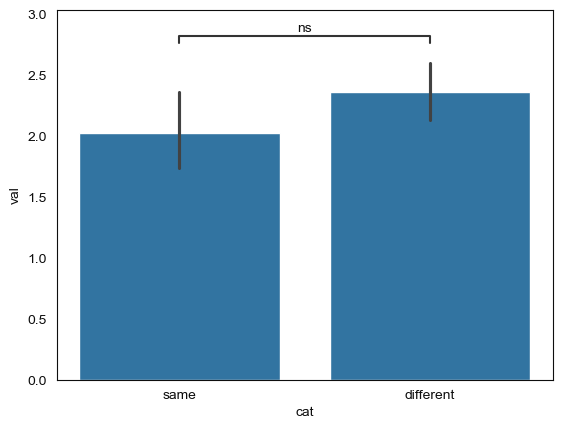

In [128]:
fig, ax = plt.subplots()

all_dis = np.hstack((same, diff))
cat = np.hstack((["same"]*len(same), ["different"]*len(diff)))

df = pd.DataFrame({"val": all_dis, "cat": cat})
sns.barplot(df, x="cat", y="val")

pairs = [("same", "different")]

annot = Annotator(None, pairs)
annot.new_plot(ax, pairs, plot='barplot',
           data=df, x="cat", y="val")
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=1)
annot.apply_test().annotate()


plt.show()

# sns.barplot(x = cat, y = all_dis)

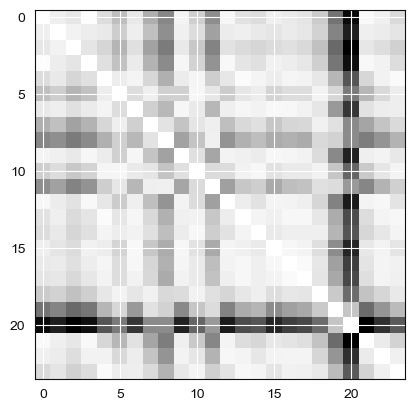

In [129]:
plt.imshow(dm, cmap='Grays', interpolation='nearest')
# dm


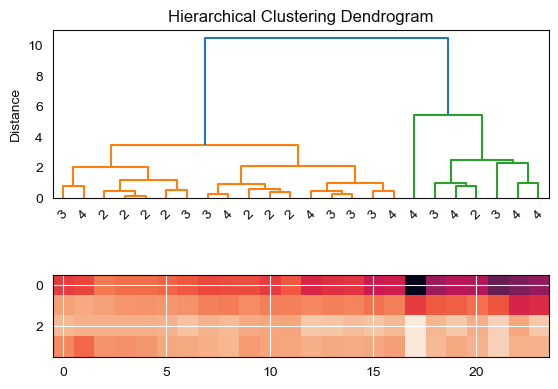

In [130]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1)

# Example distance matrix (replace with your actual data)
distance_matrix = dm

condensed_distance_matrix = squareform(np.around(distance_matrix, 5))

# Perform hierarchical clustering
linkage_matrix = linkage(condensed_distance_matrix, method='ward')



# Plot dendrogram
dendrogram(linkage_matrix, ax=axes[0], labels=np.array(cycles))
axes[0].set_title('Hierarchical Clustering Dendrogram')
# plt.xlabel('Sample index')
axes[0].set_ylabel('Distance')
# plt.show()

im = np.vstack([vectors[j] for j in leaves_list(linkage_matrix)])
axes[1].imshow(im.T,interpolation="nearest")
plt.show()

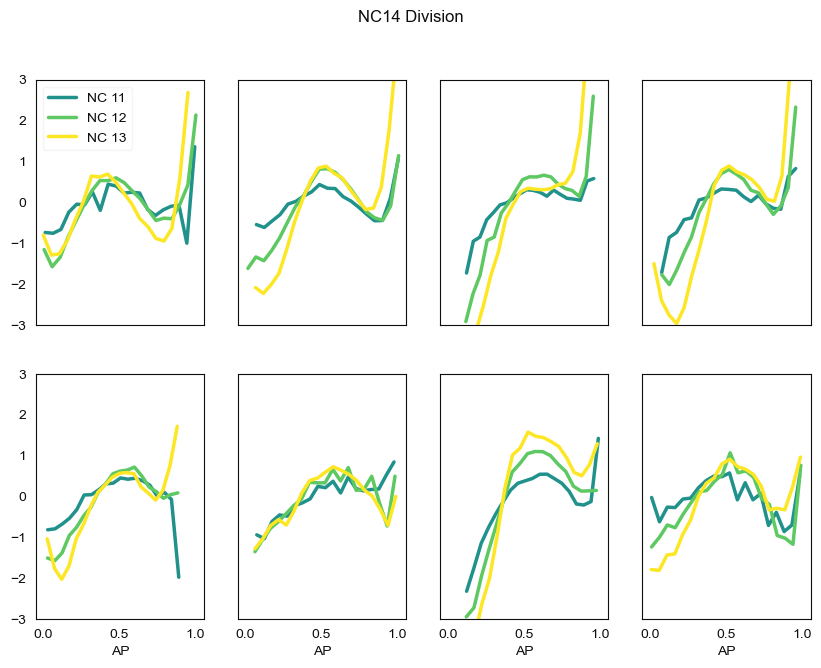

In [20]:
plt.show()
fig, axes = plt.subplots(2, 4, figsize=(10, 7), sharex=True, sharey=True)
cycle = 4

for i, (df, ax) in enumerate(zip(best_dfs, axes.flatten())):
    for cycle in [2, 3, 4]:
        color = sns.color_palette("viridis", as_cmap=True)(cycle/4)
    
        t = df[df["cycle"] == cycle].groupby("tracklet_id")
    
        x = t["AP"].last()
        x = pd.cut(t["AP"].last(), 20)
        x = x.apply(lambda v: (v.left + v.right) / 2)
        
        num_in_bin = x.value_counts() > len(x) * 0.02
        counts = x.map(num_in_bin)
        
        y = np.array(t["time"].max())
        y = y - np.mean(y)
        sns.lineplot(x=x[counts], y=y[counts], ax=ax, color=color, legend=False, err_style=None, dashes=False, label=f"NC {cycle + 9}", linewidth=2.5)
    
        ax.set_ylim([-3, 3])

# custom_lines = [Line2D([0], [0], color=colors[1], lw=2),
#                 Line2D([0], [0], color=colors[0], lw=2)]
# 
# axes.flatten()[0].legend(custom_lines, ["Trk null", "WT"])
axes.flatten()[0].legend()


plt.suptitle(f"NC{cycle + 10} Division")
plt.savefig(save_path / f"ap_division_cycle_length_{cycle + 10}_comparison.png", dpi=300)

plt.show()

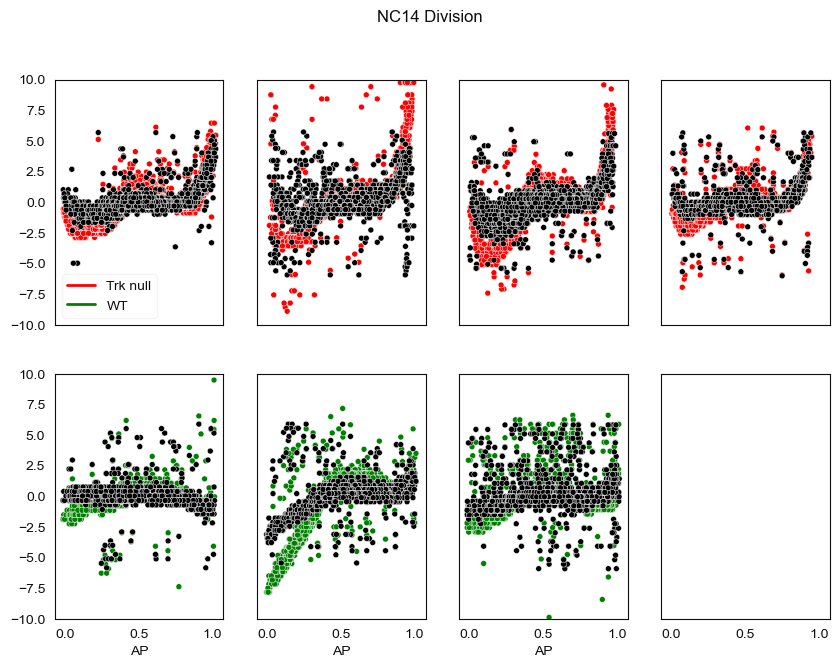

In [65]:
plt.show()
fig, axes = plt.subplots(2, 4, figsize=(10, 7), sharex=True, sharey=True)
cycle = 4

for i, (df, ax) in enumerate(zip(best_dfs, axes.flatten())):
    color = colors[trk[i]]

    t = df[df["cycle"] == cycle].groupby("tracklet_id")

    x = t["AP"].last()
    # x = pd.cut(t["AP"].last(), 20)
    # x = x.apply(lambda v: (v.left + v.right) / 2)

    y = np.array(t["time"].max())
    y = y - np.mean(y)
    sns.scatterplot(x=x, y=y, ax=ax, color=color, size=1, legend=False)

    y = np.array(t["time"].max() - t["time"].min())
    y = y - np.mean(y)
    sns.scatterplot(x=x, y=y, ax=ax, color="k", size=1, legend=False)

    ax.set_ylim([-10, 10])

custom_lines = [Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[0], lw=2)]

axes.flatten()[0].legend(custom_lines, ["Trk null", "WT"])

plt.savefig(save_path / f"ap_division_cycle_length_{cycle + 10}_comparisonscatter.png", dpi=300)
plt.suptitle(f"NC{cycle + 10} Division")

plt.show()

In [ ]:
from napari.utils.theme import get_theme, register_theme

viewer = napari.Viewer(ndisplay=3)

df = best_dfs[0]
cycle = 5
tracklets = df[df["cycle"] == cycle].groupby("tracklet_id")

position = tracklets[["z", "y", "x"]].last() * 2

track_id = tracklets["track_id"].last()

gpal = create_palette(100)
color = [gpal[int(tid) % 100] for tid in track_id]


bg_color = "#F1CCB5"
blue_theme = get_theme('dark')
blue_theme.id = 'custom'
blue_theme.canvas = "#F1CCB5"
register_theme('custom', blue_theme, 'custom')
viewer.theme = 'custom'

layer = viewer.add_points(position, face_color=color, size=14, border_color="k", antialiasing=0, border_width=1, border_width_is_relative=False,
                  experimental_clipping_planes = [{
                      "position": (0, 0, 0),
                      "normal": (0, 0, 1),
                      "enabled": True
                  }])

viewer.camera.zoom = 0.99
viewer.camera.angles = (0, 0, 90)
mean_pos = viewer.camera.center

frames = 240

tmp_out_path = Path(r"D:\OneDrive - Princeton University\Lab Meetings\2025_06_04 Toettch\gif_tmp2")

for frame in tqdm(range(frames)):
    theta = frame*(360 / frames)

    viewer.camera.angles = (0, theta, 90)
    viewer.camera.center = (mean_pos[0], mean_pos[1] + 5*np.sin(2*np.deg2rad(theta)), mean_pos[2])
    viewer.screenshot(tmp_out_path / f"wave_frame_{frame}.png", canvas_only=True, scale=1)

In [53]:
from napari.utils.theme import get_theme, register_theme

viewer = napari.Viewer(ndisplay=3)

df = best_dfs[4]
cycle = 4
tracklets = df[df["cycle"] == cycle].groupby("tracklet_id")

position = tracklets[["z", "y", "x"]].last()
first = tracklets["time"].min()

t_min = np.quantile(first, 0.01)
t_max = np.quantile(first, 0.98)

clipped = np.clip((first - t_min)/(t_max - t_min), 0, 1)

in_range = (first >= t_min) & (first <= t_max)

color = sns.color_palette("viridis", as_cmap=True)(clipped)

color[~in_range] = [0.2, 0.2, 0.2, 0]

bg_color = "#F1CCB5"
blue_theme = get_theme('dark')
blue_theme.id = 'custom'
blue_theme.canvas = "#F1CCB5"
register_theme('custom', blue_theme, 'custom')
viewer.theme = 'custom'

viewer.add_points(position[in_range], face_color=color[in_range], size=8, border_color="k")

viewer.camera.zoom = 0.75
viewer.camera.angles = (0, 0, 90)
mean_pos = viewer.camera.center

frames = 240

tmp_out_path = Path(r"D:\OneDrive - Princeton University\Lab Meetings\2025_06_04 Toettch\gif_tmp")

for frame in tqdm(range(frames)):
    theta = frame*(360 / frames)
    
    viewer.camera.angles = (0, theta, 90)
    viewer.camera.center = (mean_pos[0], mean_pos[1] + 5*np.sin(2*np.deg2rad(theta)), mean_pos[2])
    viewer.screenshot(tmp_out_path / f"wave_frame_{frame}.png", canvas_only=True, scale=2)

100%|██████████| 240/240 [00:41<00:00,  5.78it/s]


In [92]:
from napari.utils.theme import get_theme, register_theme

def to_hex(col):
    if isinstance(col, str):
        return col
    else:
        return "#{:02x}{:02x}{:02x}".format(int(col[0]*255), int(col[1]*255), int(col[2]*255))
    
def get_nn_values(loc, vals, neighbors=5):
    knn = NearestNeighbors(n_neighbors=neighbors)
    knn.fit(loc, vals)
    n = knn.kneighbors(loc, return_distance=False)
    fit_values = vals.values[n]
    fit_values = np.array(np.median(fit_values, axis=1), dtype=int)

    return fit_values

palette = sns.color_palette("mako", n_colors=5)[0:]
palette = [to_hex(x) for x in palette]
choice = 2

best_spots = dfs[choice]
interphase_dividers = all_cycle_starts[choice][1:]

# final_tracklets = best_spots.groupby("track_id")["FRAME"].max() >= best_spots["FRAME"].max() - 10
# best_spots = best_spots[best_spots["track_id"].map(final_tracklets)]
best_spots = best_spots[best_spots["z"] > best_spots["z"].mean() + 10]


viewer = napari.Viewer(ndisplay=3)
bg_color = "#F1CCB5"
blue_theme = get_theme('dark')
blue_theme.id = 'custom'
blue_theme.canvas = "#F1CCB5"
register_theme('custom', blue_theme, 'custom')
viewer.theme = 'custom'

fmin = 1000
fmax = 0

tracklets = best_spots.groupby("tracklet_id")
ts = tracklets["FRAME"].min()
te = tracklets["FRAME"].max()

locs = []
colors = []

for i, (start, end) in enumerate(zip(interphase_dividers[:-1], interphase_dividers[1:])):
    subset = best_spots[(best_spots["FRAME"] >= start) & (best_spots["FRAME"] < end)]
    
    isin_t = ((ts < start) & (ts > start)) ^ ((ts < end) & (te > start))
    isin = subset["tracklet_id"].map(isin_t)
    
    subset = subset[isin]
    loc = subset[["FRAME", "x", "y", "z"]]
    locs.append(loc)
    
    new_pt = subset["tracklet_id"].map(ts > start)
    
    tloc = loc.values.copy()
    tloc[:, 0] = tloc[:, 0]*100
    fit_pt = get_nn_values(tloc, new_pt, neighbors=5)
    print(np.sum(fit_pt != new_pt))
    
    color = [palette[i + 1] if x else "#444444" for x in fit_pt]
    
    print(len(loc))
    print(len(color))
    # print(color)
    
    fmin = int(min(fmin, np.min(subset["FRAME"])))
    fmax = int(max(fmax, np.max(subset["FRAME"])))
    
    colors.extend(color)

colors = np.array(colors)
locs = np.concatenate(locs)
viewer.add_points(locs, face_color=colors, size=7, border_color="k")

fmin = np.min(best_spots["FRAME"])
fmax = np.max(best_spots["FRAME"])

colors = np.array(color)

viewer.camera.zoom = 0.95
viewer.camera.angles = (0, 90, 90)

wave_img_path =  save_path / f"wave_{chr(ord('A') + choice)}"
wave_img_path.mkdir(exist_ok=True)

for frame in tqdm(range(0, int(fmax))):
    viewer.dims.set_point(0, frame)
    viewer.screenshot(wave_img_path / f"wave_frame_{frame}.png", canvas_only=True, scale=2)

229
5407
5407
394
19708
19708
1533
94170
94170
1898
131361
131361


100%|██████████| 280/280 [00:47<00:00,  5.88it/s]
